In [112]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, acf
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from functools import reduce
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge


df = pd.read_csv('/Users/jojolapatate/Documents/GitHub/The-Endless-Line/The-Endless-Line_jo/final_data_day.csv')
df_15 = pd.read_csv('/Users/jojolapatate/Downloads/final_data_15min.csv')

pd.set_option('display.max_columns', None)

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/2676759612.py:23: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_15 = pd.read_csv('/Users/jojolapatate/Downloads/final_data_15min.csv')


In [114]:
#Filter before Covid, Filter out when park/attraction is closed based on these assumptions
df_15['DATE'] = pd.to_datetime(df_15['DATE'])
df_15_bis = df_15[df_15['DATE'].dt.year > 2020]
df_15_bis = df_15_bis[df_15_bis['GUEST CARRIED'] != 0]
df_15_bis = df_15_bis[df_15_bis['ATTENDANCE'] != 0]
df_15_bis = df_15_bis[df_15_bis['ADJUST CAPACITY'] != 0]

In [ ]:
#Adding new features

df_15_bis['Ratio People/Capacity'] =df_15_bis['GUEST CARRIED']/df_15_bis['ADJUST CAPACITY']
df_15_bis = df_15_bis[df_15_bis['Ratio People/Capacity'] <= 1]
df_15_bis['Hour'] = pd.to_datetime(df_15_bis['HOUR START OF 1 RIDE'], format='%H').dt.hour
df_15_bis['DayOfWeek'] = pd.to_datetime(df_15_bis['DATE']).dt.dayofweek
df_15_bis['Month'] = pd.to_datetime(df_15_bis['DATE']).dt.month
df_15_bis['IsWeekend'] = pd.to_datetime(df_15_bis['DATE']).dt.dayofweek // 5
df_15_bis['IsPeakHour'] = df_15_bis['Hour'].apply(lambda x: 1 if 10 <= x <= 18 else 0)

df_15_bis['PreviousDayWaitTime'] = df_15_bis.groupby('ATTRACTION NAME')['WAIT TIME'].shift(1)
df_15_bis['RollingAvgWaitTime'] = df_15_bis.groupby('ATTRACTION NAME')['WAIT TIME'].transform(lambda x: x.rolling(window=3).mean())

In [115]:
#Calculate MAPE

def calculate_mape(y_actual, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE) between actual and predicted values.
    
    :param y_actual: The actual values.
    :param y_pred: The predicted values.
    :return: The MAPE as a percentage.
    """
    # Ensure no division by zero
    y_actual, y_pred = np.array(y_actual), np.array(y_pred)
    nonzero_indices = y_actual != 0
    mape = np.mean(np.abs((y_actual[nonzero_indices] - y_pred[nonzero_indices]) / y_actual[nonzero_indices])) * 100
    return mape

In [ ]:
df_15_bis.sort_values('DATE', inplace = True)

df_15_bis.drop(columns = ['START OF 1 RIDE FOR ATTRACTION',\
                          'END OF 1 RIDE FOR ATTRACTION', 'ATTRACTION'], inplace = True)


attractions_name = df_15_bis['ATTRACTION NAME'].unique()

df_15_bis.dropna(inplace= True)

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Giant Wheel: 10.0
MAPE for Giant Wheel: 14.67
R-squared for Giant Wheel: 0.8078
                                 Variable  Coefficient
1                           GUEST CARRIED    -0.117146
14                            IS PARADE 1    -0.059951
16                  Ratio People/Capacity    -0.056966
8                                HUMIDITY    -0.039181
17                              DayOfWeek    -0.028746
4   REAL TIME ATTRACTION CLOSES FOR 15MIN    -0.023623
13                          IS NIGHT SHOW    -0.014257
6                             TEMPERATURE    -0.013098
7                                PRESSURE    -0.009565
18                                  Month    -0.007753
3     REAL TIME ATTRACTION OPEN FOR 15MIN    -0.002273
2                                CAPACITY    -0.001994
5                            NB MAX UNITS     0.000000
15                            IS PARADE 2     0.000000
0                                NB UNITS     0.003703
9                        

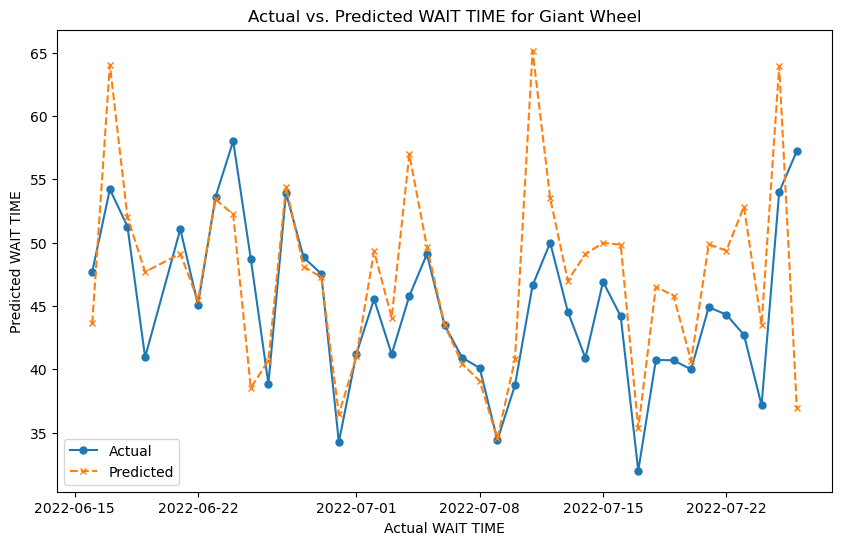

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Merry Go Round: 10.0
MAPE for Merry Go Round: 31.67
R-squared for Merry Go Round: 0.5254
                                 Variable  Coefficient
14                            IS PARADE 1    -0.225423
3     REAL TIME ATTRACTION OPEN FOR 15MIN    -0.070902
17                              DayOfWeek    -0.060085
0                                NB UNITS    -0.056556
8                                HUMIDITY    -0.054103
1                           GUEST CARRIED    -0.029934
6                             TEMPERATURE    -0.027645
4   REAL TIME ATTRACTION CLOSES FOR 15MIN    -0.018125
13                          IS NIGHT SHOW    -0.015883
5                            NB MAX UNITS     0.000000
15                            IS PARADE 2     0.000000
16                  Ratio People/Capacity     0.010115
7                                PRESSURE     0.026627
11                       CLOUD PERCENTAGE     0.039117
2                                CAPACITY     0.050535
19              

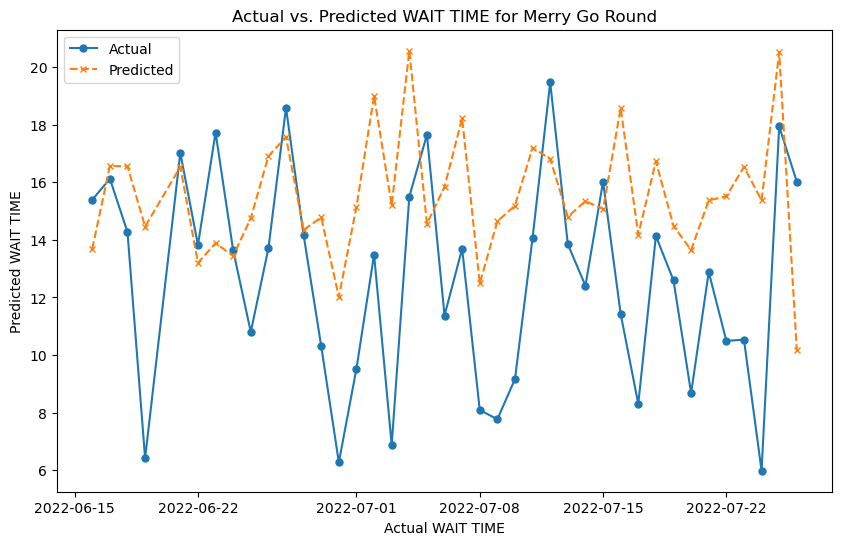

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Inverted Coaster: 10.0
MAPE for Inverted Coaster: 24.15
R-squared for Inverted Coaster: 0.4340
                                 Variable  Coefficient
0                                NB UNITS    -0.127733
1                           GUEST CARRIED    -0.096038
16                  Ratio People/Capacity    -0.040234
20                             IsPeakHour    -0.035454
6                             TEMPERATURE    -0.031035
19                              IsWeekend    -0.027966
11                       CLOUD PERCENTAGE    -0.003406
5                            NB MAX UNITS     0.000000
15                            IS PARADE 2     0.000000
13                          IS NIGHT SHOW     0.000000
8                                HUMIDITY     0.003363
17                              DayOfWeek     0.004534
4   REAL TIME ATTRACTION CLOSES FOR 15MIN     0.011843
2                                CAPACITY     0.013194
10                               WIND DEG     0.019819
18        

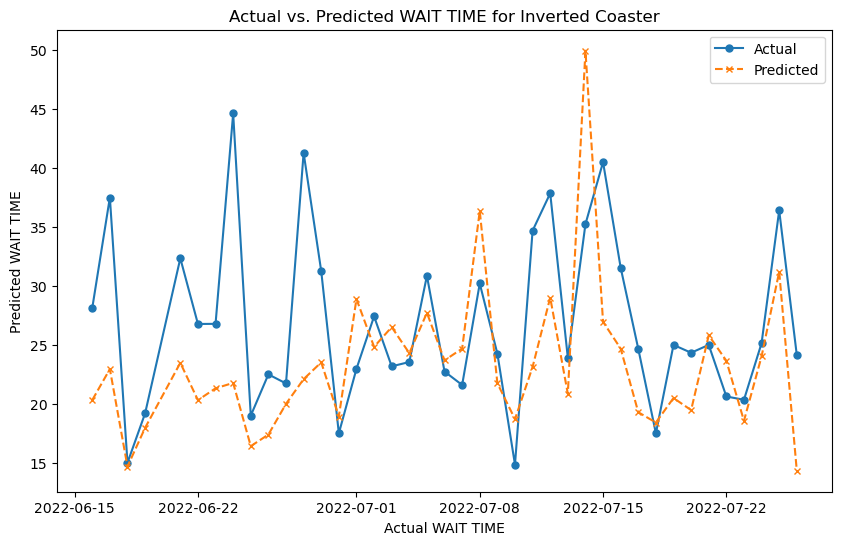

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Bungee Jump: 10.0
MAPE for Bungee Jump: 23.43
R-squared for Bungee Jump: 0.6745
                                 Variable  Coefficient
1                           GUEST CARRIED    -0.097972
14                            IS PARADE 1    -0.079881
17                              DayOfWeek    -0.055583
18                                  Month    -0.044268
3     REAL TIME ATTRACTION OPEN FOR 15MIN    -0.039979
6                             TEMPERATURE    -0.028117
11                       CLOUD PERCENTAGE    -0.023438
20                             IsPeakHour    -0.012187
8                                HUMIDITY    -0.000994
5                            NB MAX UNITS     0.000000
13                          IS NIGHT SHOW     0.000000
15                            IS PARADE 2     0.000000
4   REAL TIME ATTRACTION CLOSES FOR 15MIN     0.002437
7                                PRESSURE     0.007219
9                              WIND SPEED     0.007356
2                        

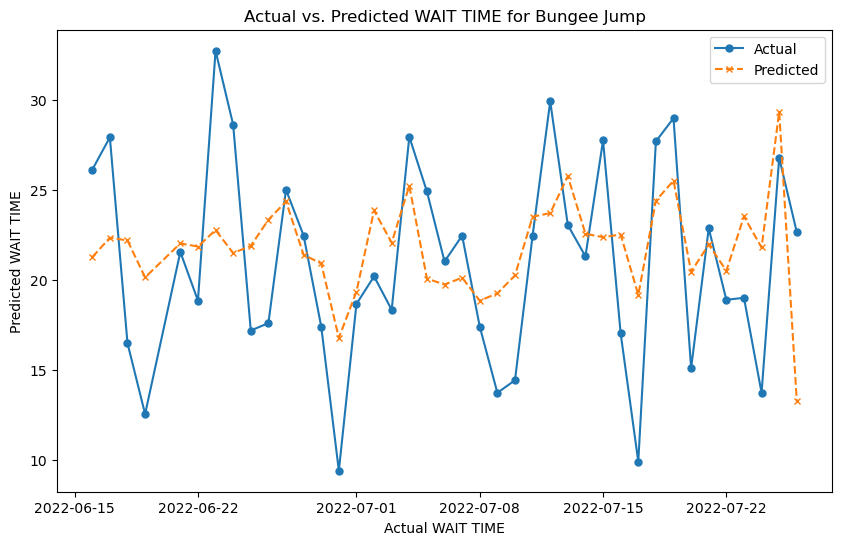

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Superman Ride: 10.0
MAPE for Superman Ride: 33.79
R-squared for Superman Ride: 0.2071
                                 Variable  Coefficient
1                           GUEST CARRIED    -0.097859
20                             IsPeakHour    -0.050988
16                  Ratio People/Capacity    -0.048579
14                            IS PARADE 1    -0.041883
8                                HUMIDITY    -0.029088
18                                  Month    -0.019055
0                                NB UNITS    -0.013046
3     REAL TIME ATTRACTION OPEN FOR 15MIN    -0.006410
4   REAL TIME ATTRACTION CLOSES FOR 15MIN    -0.003662
12                             ATTENDANCE    -0.000987
5                            NB MAX UNITS     0.000000
13                          IS NIGHT SHOW     0.000000
15                            IS PARADE 2     0.000000
17                              DayOfWeek     0.019304
7                                PRESSURE     0.021002
10                 

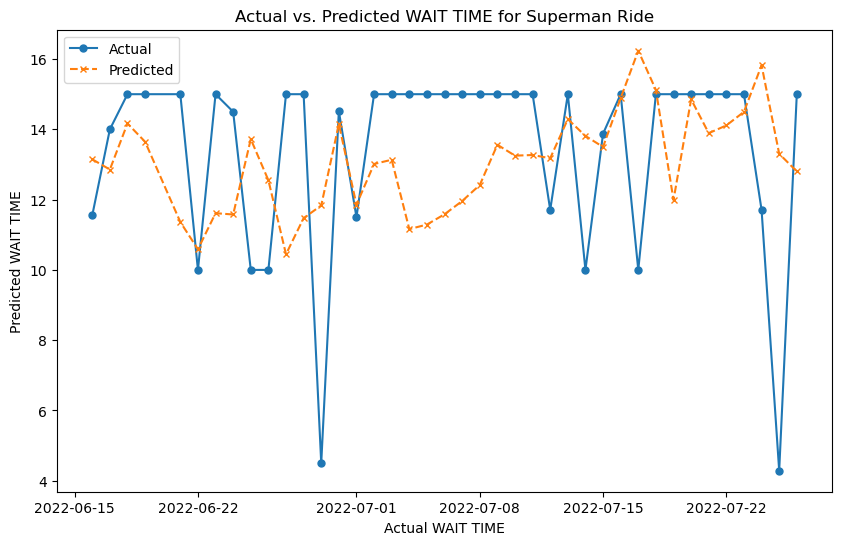

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Circus Train: 10.0
MAPE for Circus Train: 10.90
R-squared for Circus Train: 0.2283
                                 Variable  Coefficient
16                  Ratio People/Capacity    -0.023837
1                           GUEST CARRIED    -0.022359
19                              IsWeekend    -0.020884
2                                CAPACITY    -0.014836
7                                PRESSURE    -0.007189
17                              DayOfWeek    -0.006240
11                       CLOUD PERCENTAGE    -0.001600
8                                HUMIDITY    -0.000969
20                             IsPeakHour    -0.000531
18                                  Month    -0.000357
15                            IS PARADE 2     0.000000
13                          IS NIGHT SHOW     0.000000
0                                NB UNITS     0.000000
5                            NB MAX UNITS     0.000000
6                             TEMPERATURE     0.003517
9                     

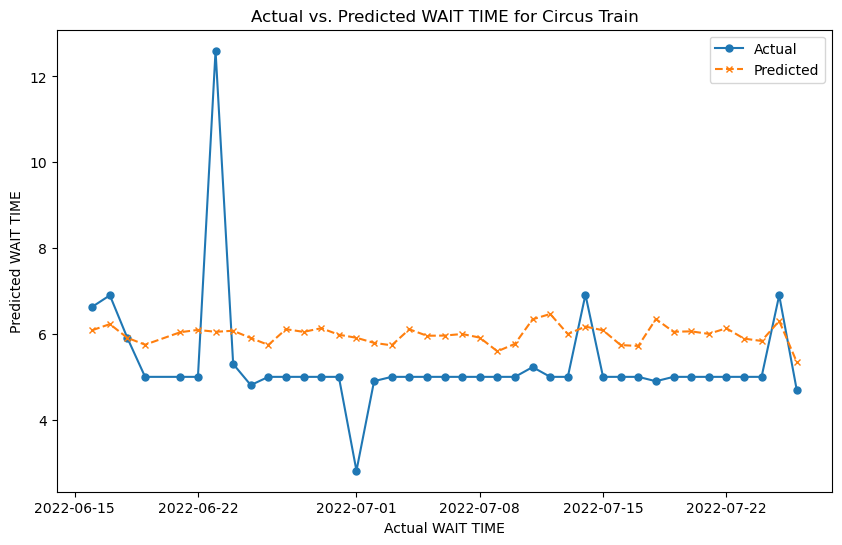

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Dizzy Dropper: 10.0
MAPE for Dizzy Dropper: 17.68
R-squared for Dizzy Dropper: 0.6901
                                 Variable  Coefficient
1                           GUEST CARRIED    -0.088714
15                            IS PARADE 1    -0.082755
17                  Ratio People/Capacity    -0.066941
9                                HUMIDITY    -0.035757
5   REAL TIME ATTRACTION CLOSES FOR 15MIN    -0.018579
4     REAL TIME ATTRACTION OPEN FOR 15MIN    -0.012388
20                              IsWeekend    -0.006322
0                                NB UNITS    -0.005215
3                         ADJUST CAPACITY    -0.004930
18                              DayOfWeek    -0.004381
8                                PRESSURE    -0.001634
6                            NB MAX UNITS     0.000000
16                            IS PARADE 2     0.000000
14                          IS NIGHT SHOW     0.000000
21                             IsPeakHour     0.000405
19                 

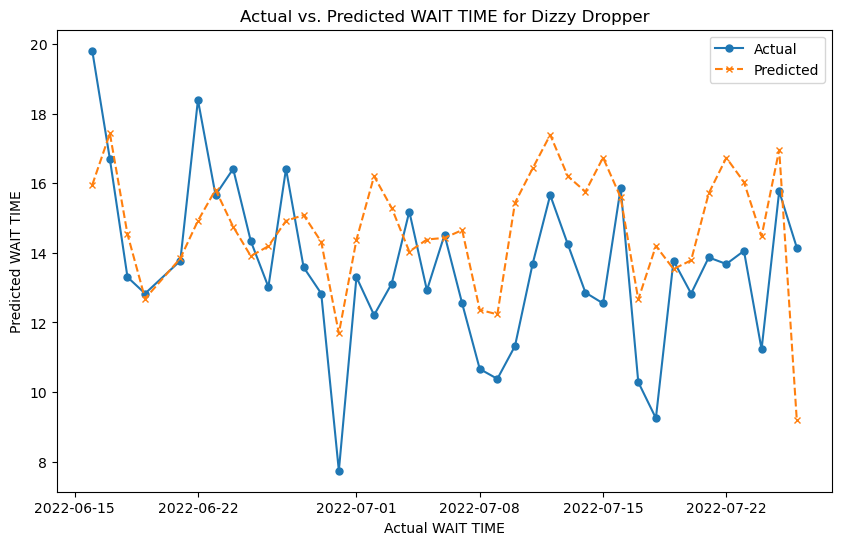

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Drop Tower: 10.0
MAPE for Drop Tower: 16.11
R-squared for Drop Tower: 0.7214
                                 Variable  Coefficient
15                            IS PARADE 1    -0.102653
9                                HUMIDITY    -0.058976
20                              IsWeekend    -0.016319
5   REAL TIME ATTRACTION CLOSES FOR 15MIN    -0.011998
1                           GUEST CARRIED    -0.011949
18                              DayOfWeek    -0.008577
4     REAL TIME ATTRACTION OPEN FOR 15MIN    -0.000827
6                            NB MAX UNITS     0.000000
16                            IS PARADE 2     0.000000
14                          IS NIGHT SHOW     0.000000
3                         ADJUST CAPACITY     0.002843
0                                NB UNITS     0.005465
21                             IsPeakHour     0.009268
10                             WIND SPEED     0.009817
17                  Ratio People/Capacity     0.013911
8                           

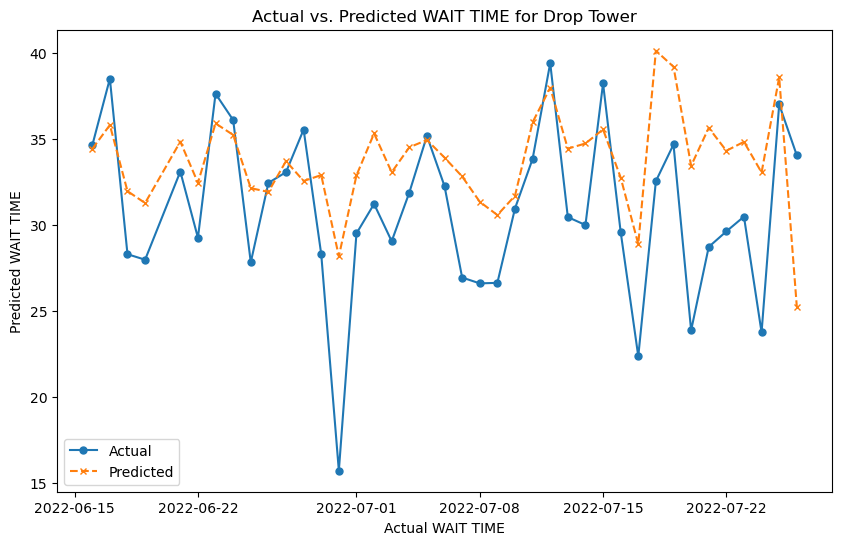

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Kiddie Coaster: 10.0
MAPE for Kiddie Coaster: 24.06
R-squared for Kiddie Coaster: 0.5785
                                 Variable  Coefficient
9                                HUMIDITY    -0.047664
12                       CLOUD PERCENTAGE    -0.037230
18                              DayOfWeek    -0.025348
19                                  Month    -0.024656
0                                NB UNITS    -0.024332
1                           GUEST CARRIED    -0.010286
20                              IsWeekend    -0.007814
3                         ADJUST CAPACITY    -0.005822
16                            IS PARADE 2     0.000000
6                            NB MAX UNITS     0.000000
14                          IS NIGHT SHOW     0.000000
7                             TEMPERATURE     0.000824
10                             WIND SPEED     0.001991
2                                CAPACITY     0.006375
5   REAL TIME ATTRACTION CLOSES FOR 15MIN     0.006382
4     REAL TIME 

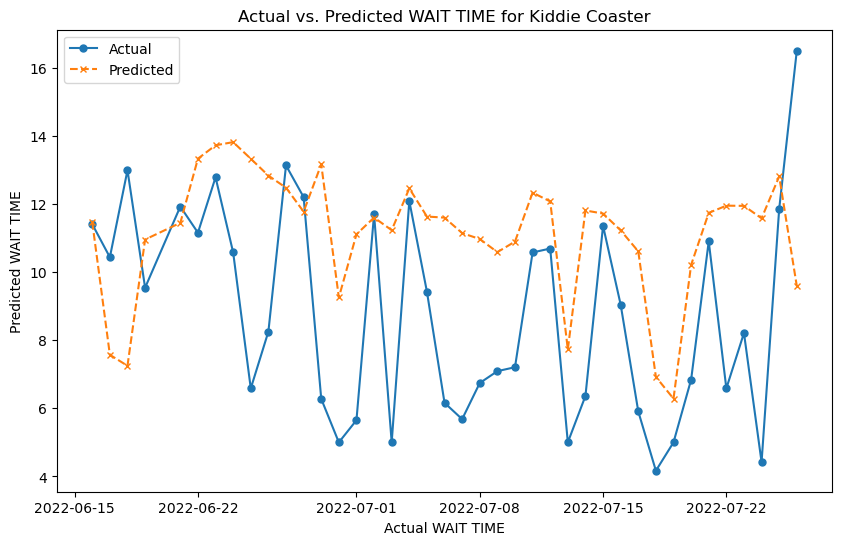

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Free Fall: 10.0
MAPE for Free Fall: 13.71
R-squared for Free Fall: 0.7615
                                 Variable  Coefficient
1                           GUEST CARRIED    -0.104336
17                                  Month    -0.067022
18                              IsWeekend    -0.057611
15                  Ratio People/Capacity    -0.049266
11                       CLOUD PERCENTAGE    -0.031400
10                               WIND DEG    -0.022093
6                             TEMPERATURE    -0.018621
7                                PRESSURE    -0.017870
9                              WIND SPEED    -0.008127
2                                CAPACITY    -0.001312
5                            NB MAX UNITS     0.000000
14                            IS PARADE 2     0.000000
13                          IS NIGHT SHOW     0.000000
4   REAL TIME ATTRACTION CLOSES FOR 15MIN     0.005326
0                                NB UNITS     0.005834
16                             

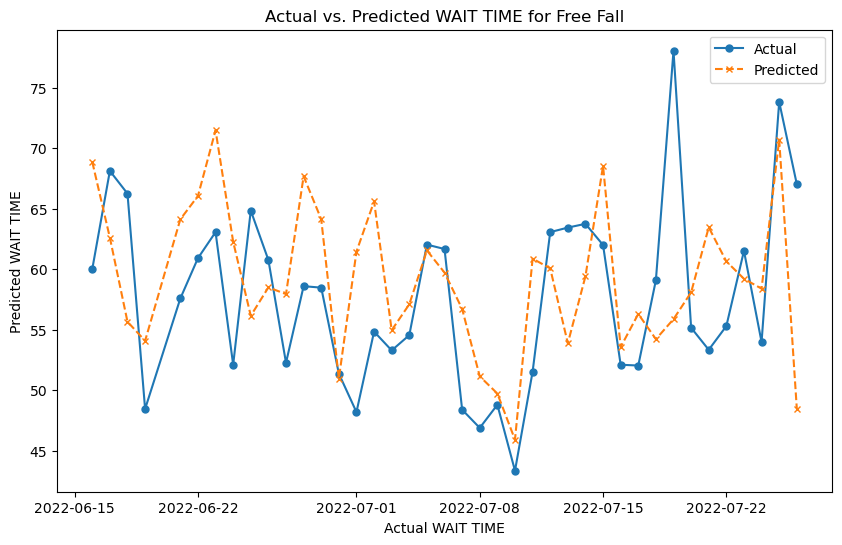

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Spinning Coaster: 10.0
MAPE for Spinning Coaster: 18.32
R-squared for Spinning Coaster: 0.6491
                                 Variable  Coefficient
14                            IS PARADE 1    -0.202745
1                           GUEST CARRIED    -0.089976
16                  Ratio People/Capacity    -0.071391
18                                  Month    -0.059738
3     REAL TIME ATTRACTION OPEN FOR 15MIN    -0.045952
6                             TEMPERATURE    -0.036896
19                              IsWeekend    -0.026141
17                              DayOfWeek    -0.019496
11                       CLOUD PERCENTAGE    -0.001186
7                                PRESSURE    -0.000338
15                            IS PARADE 2     0.000000
5                            NB MAX UNITS     0.000000
13                          IS NIGHT SHOW     0.000000
4   REAL TIME ATTRACTION CLOSES FOR 15MIN     0.000206
8                                HUMIDITY     0.004168
10        

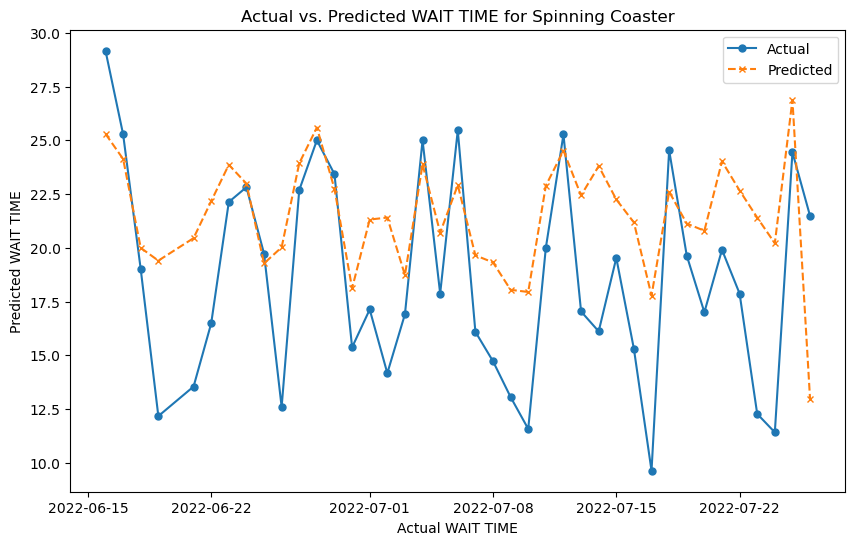

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Swing Ride: 10.0
MAPE for Swing Ride: 16.03
R-squared for Swing Ride: 0.7319
                                 Variable  Coefficient
1                           GUEST CARRIED    -0.148855
16                  Ratio People/Capacity    -0.134062
20                             IsPeakHour    -0.090777
18                                  Month    -0.081869
8                                PRESSURE    -0.057674
11                               WIND DEG    -0.034806
10                             WIND SPEED    -0.032563
17                              DayOfWeek    -0.021716
0                                NB UNITS    -0.016620
14                            IS PARADE 1    -0.014510
5   REAL TIME ATTRACTION CLOSES FOR 15MIN    -0.011065
13                          IS NIGHT SHOW     0.000000
15                            IS PARADE 2     0.000000
6                            NB MAX UNITS     0.000000
9                                HUMIDITY     0.004381
12                       CLO

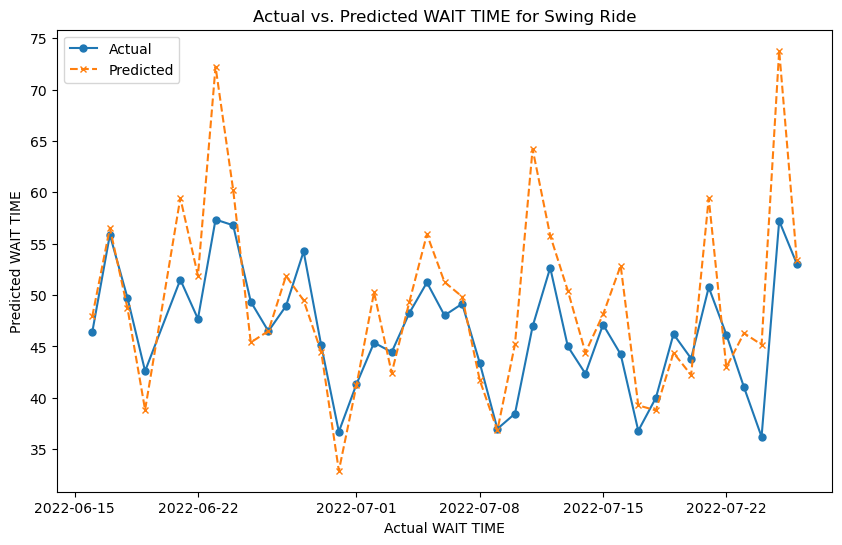

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Roller Coaster: 10.0
MAPE for Roller Coaster: 11.90
R-squared for Roller Coaster: 0.6908
                                 Variable  Coefficient
19                              IsWeekend    -0.063801
18                                  Month    -0.057768
16                  Ratio People/Capacity    -0.046700
0                                NB UNITS    -0.021816
1                           GUEST CARRIED    -0.016073
8                                HUMIDITY    -0.009584
3     REAL TIME ATTRACTION OPEN FOR 15MIN    -0.001490
6                             TEMPERATURE    -0.000153
5                            NB MAX UNITS     0.000000
15                            IS PARADE 2     0.000000
13                          IS NIGHT SHOW     0.000000
11                       CLOUD PERCENTAGE     0.001818
4   REAL TIME ATTRACTION CLOSES FOR 15MIN     0.002164
14                            IS PARADE 1     0.004208
9                              WIND SPEED     0.015915
10              

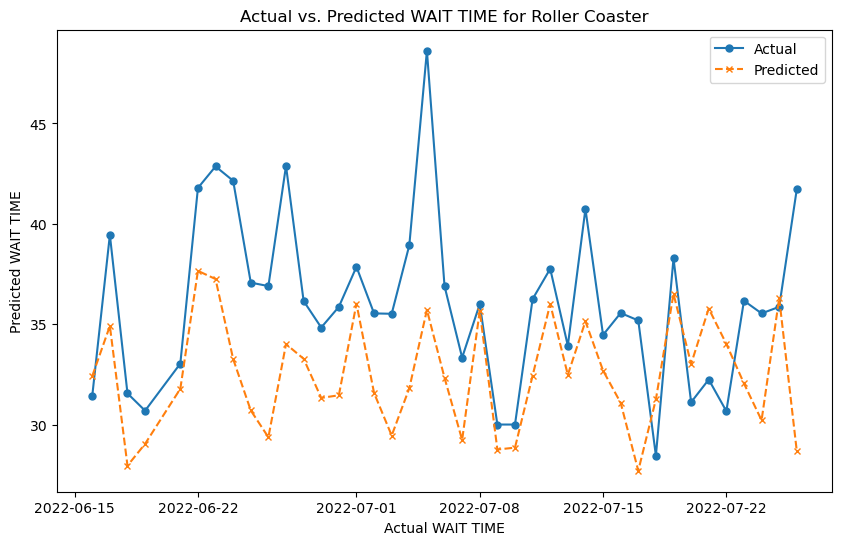

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Flying Coaster: 10.0
MAPE for Flying Coaster: 30.55
R-squared for Flying Coaster: 0.3638
                                 Variable  Coefficient
1                           GUEST CARRIED    -0.157417
15                            IS PARADE 1    -0.138440
17                  Ratio People/Capacity    -0.067804
3                         ADJUST CAPACITY    -0.058603
18                              DayOfWeek    -0.054921
7                             TEMPERATURE    -0.022084
19                                  Month    -0.021683
12                       CLOUD PERCENTAGE    -0.020324
16                            IS PARADE 2     0.000000
14                          IS NIGHT SHOW     0.000000
6                            NB MAX UNITS     0.000000
8                                PRESSURE     0.002790
9                                HUMIDITY     0.003726
10                             WIND SPEED     0.018017
20                              IsWeekend     0.032134
4     REAL TIME 

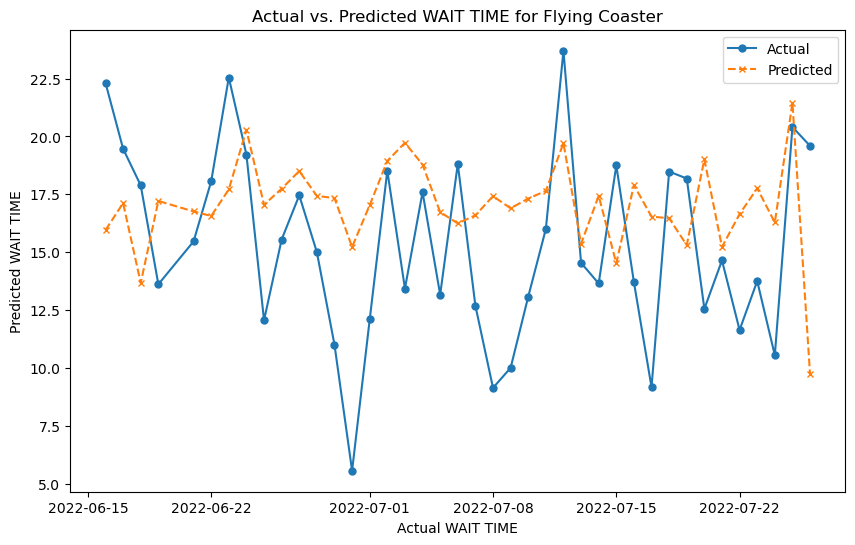

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Water Ride: 0.001
MAPE for Water Ride: 17.96
R-squared for Water Ride: 0.9537
                                 Variable  Coefficient
7                            NB MAX UNITS    -0.816928
3                         ADJUST CAPACITY    -0.651710
18                  Ratio People/Capacity    -0.199686
14                             ATTENDANCE    -0.071278
2                                CAPACITY    -0.021662
13                       CLOUD PERCENTAGE    -0.013527
10                               HUMIDITY    -0.011328
12                               WIND DEG    -0.008896
9                                PRESSURE    -0.008122
6   REAL TIME ATTRACTION CLOSES FOR 15MIN    -0.003033
17                            IS PARADE 2     0.000000
15                          IS NIGHT SHOW     0.000000
11                             WIND SPEED     0.006207
5     REAL TIME ATTRACTION OPEN FOR 15MIN     0.007866
8                             TEMPERATURE     0.008285
19                         

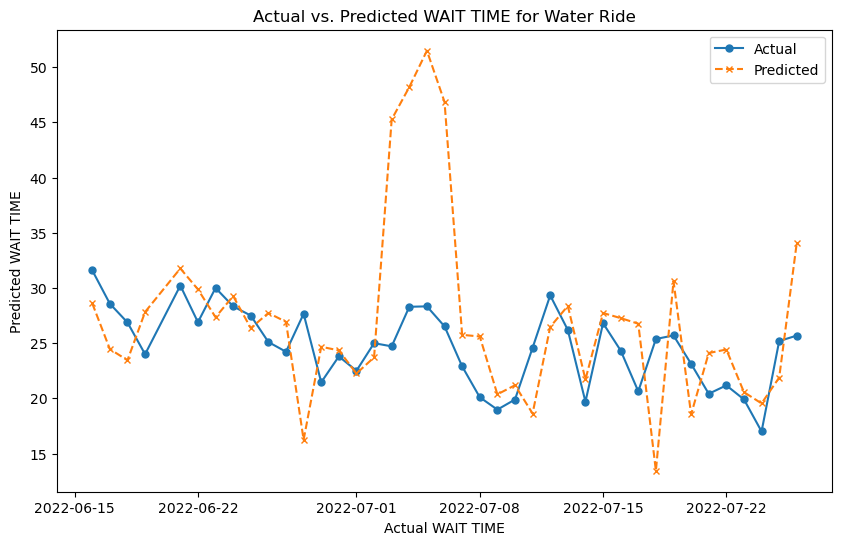

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Spiral Slide: 10.0
MAPE for Spiral Slide: 798270264.61
R-squared for Spiral Slide: 0.4811
                                 Variable  Coefficient
18                                  Month    -0.164030
20                             IsPeakHour    -0.110580
8                                HUMIDITY    -0.105019
3     REAL TIME ATTRACTION OPEN FOR 15MIN    -0.086281
19                              IsWeekend    -0.075746
6                             TEMPERATURE    -0.073102
0                                NB UNITS    -0.062832
17                              DayOfWeek    -0.035374
4   REAL TIME ATTRACTION CLOSES FOR 15MIN    -0.015543
13                          IS NIGHT SHOW     0.000000
15                            IS PARADE 2     0.000000
5                            NB MAX UNITS     0.000000
11                       CLOUD PERCENTAGE     0.013699
9                              WIND SPEED     0.018557
7                                PRESSURE     0.073467
10             

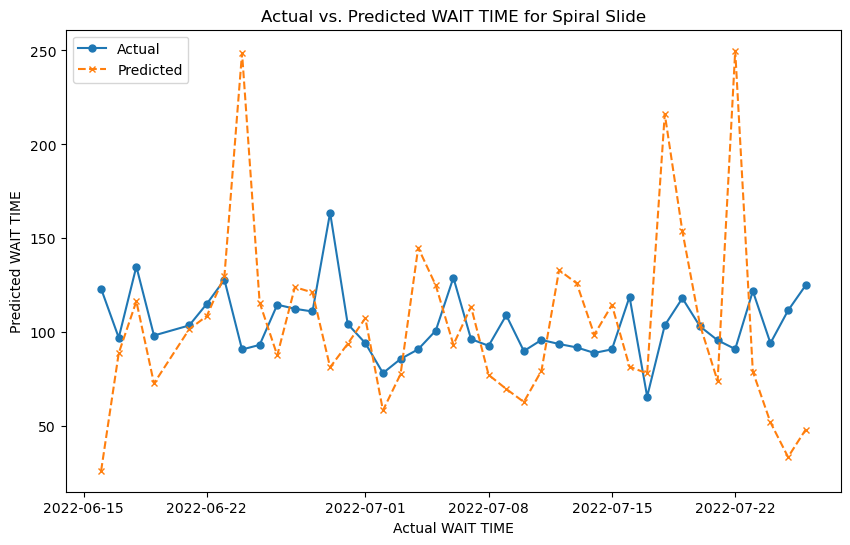

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Haunted House: 1.0
MAPE for Haunted House: 15.94
R-squared for Haunted House: 0.8525
                                 Variable  Coefficient
14                            IS PARADE 1    -0.145336
1                           GUEST CARRIED    -0.116950
18                                  Month    -0.076547
6                             TEMPERATURE    -0.048520
19                              IsWeekend    -0.033041
11                       CLOUD PERCENTAGE    -0.020452
17                              DayOfWeek    -0.017321
4   REAL TIME ATTRACTION CLOSES FOR 15MIN    -0.011099
7                                PRESSURE    -0.003759
5                            NB MAX UNITS     0.000000
13                          IS NIGHT SHOW     0.000000
15                            IS PARADE 2     0.000000
3                         ADJUST CAPACITY     0.003650
9                              WIND SPEED     0.006669
2                                CAPACITY     0.014746
10                  

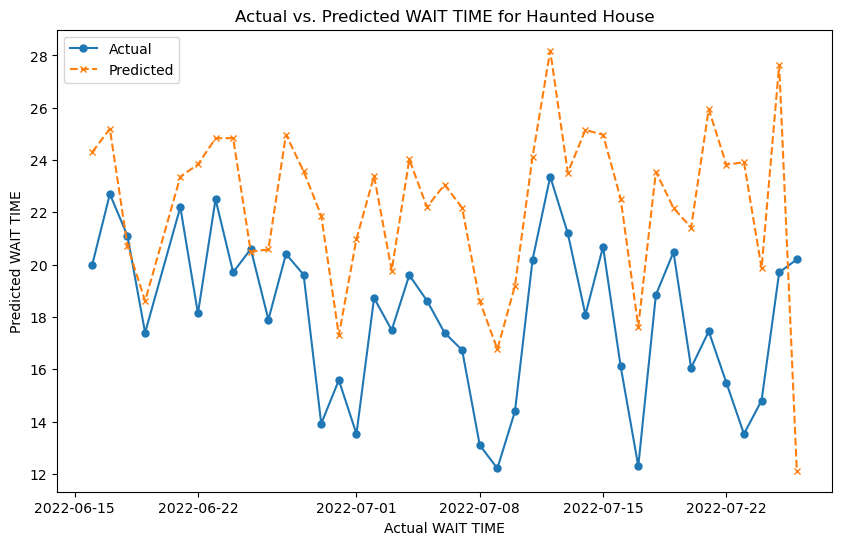

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Rapids Ride: 10.0
MAPE for Rapids Ride: 24.82
R-squared for Rapids Ride: 0.7500
                                 Variable  Coefficient
18                                  Month    -0.110306
0                                NB UNITS    -0.067004
11                       CLOUD PERCENTAGE    -0.033629
14                            IS PARADE 1    -0.031628
3     REAL TIME ATTRACTION OPEN FOR 15MIN    -0.024076
17                              DayOfWeek    -0.016183
19                              IsWeekend    -0.013436
9                              WIND SPEED    -0.012377
4   REAL TIME ATTRACTION CLOSES FOR 15MIN    -0.007574
1                           GUEST CARRIED    -0.007112
8                                HUMIDITY    -0.002567
5                            NB MAX UNITS     0.000000
15                            IS PARADE 2     0.000000
13                          IS NIGHT SHOW     0.000000
7                                PRESSURE     0.011575
20                       

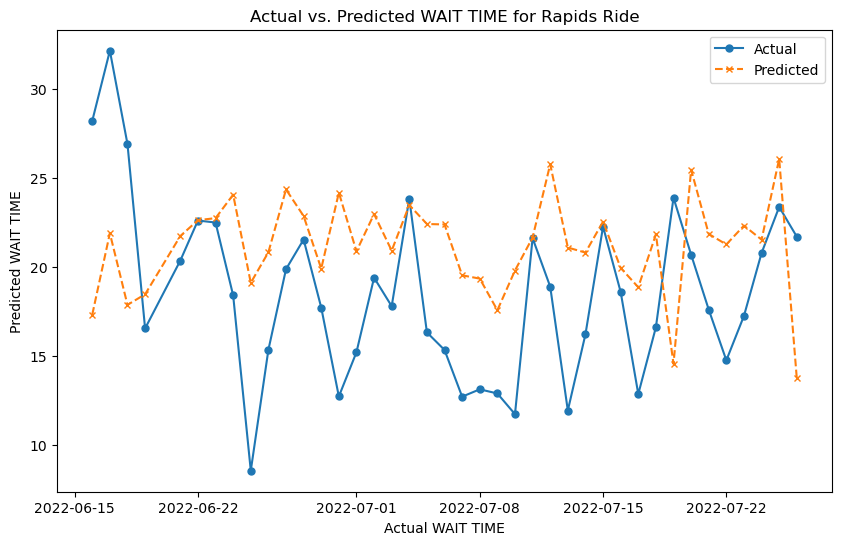

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Bumper Cars: 10.0
MAPE for Bumper Cars: 21.52
R-squared for Bumper Cars: 0.5955
                                 Variable  Coefficient
15                            IS PARADE 1    -0.120351
21                             IsPeakHour    -0.068857
9                                HUMIDITY    -0.036126
4     REAL TIME ATTRACTION OPEN FOR 15MIN    -0.030080
20                              IsWeekend    -0.018698
7                             TEMPERATURE    -0.018471
18                              DayOfWeek    -0.013549
3                         ADJUST CAPACITY    -0.013242
19                                  Month    -0.003714
12                       CLOUD PERCENTAGE    -0.003679
1                           GUEST CARRIED    -0.001469
5   REAL TIME ATTRACTION CLOSES FOR 15MIN    -0.001043
6                            NB MAX UNITS     0.000000
16                            IS PARADE 2     0.000000
14                          IS NIGHT SHOW     0.000000
17                  Ratio

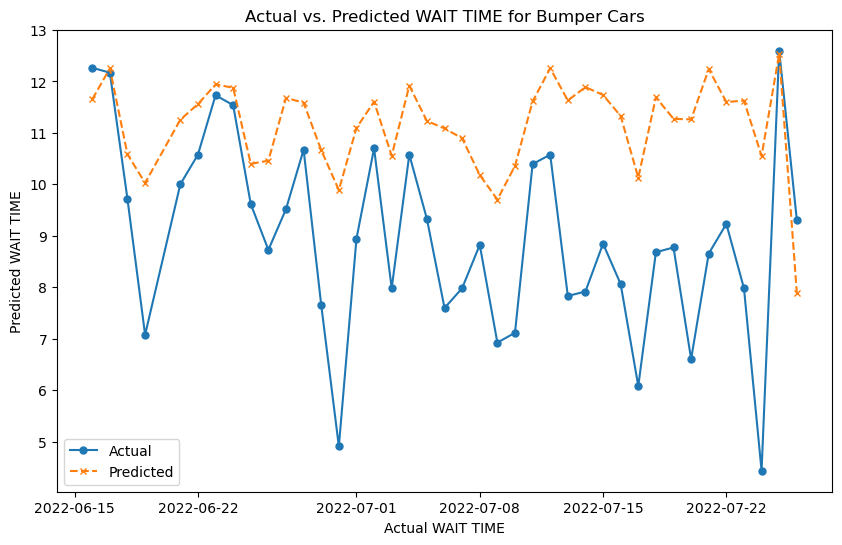

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Giga Coaster: 10.0
MAPE for Giga Coaster: 24.48
R-squared for Giga Coaster: 0.5751
                                 Variable  Coefficient
0                                NB UNITS    -0.025500
7                                PRESSURE    -0.021742
3     REAL TIME ATTRACTION OPEN FOR 15MIN    -0.021552
2                                CAPACITY    -0.004713
19                             IsPeakHour    -0.000577
5                            NB MAX UNITS     0.000000
12                          IS NIGHT SHOW     0.000000
13                            IS PARADE 1     0.000000
14                            IS PARADE 2     0.000000
4   REAL TIME ATTRACTION CLOSES FOR 15MIN     0.011369
11                       CLOUD PERCENTAGE     0.013368
6                             TEMPERATURE     0.015110
8                                HUMIDITY     0.017095
9                              WIND SPEED     0.021099
17                                  Month     0.023499
16                    

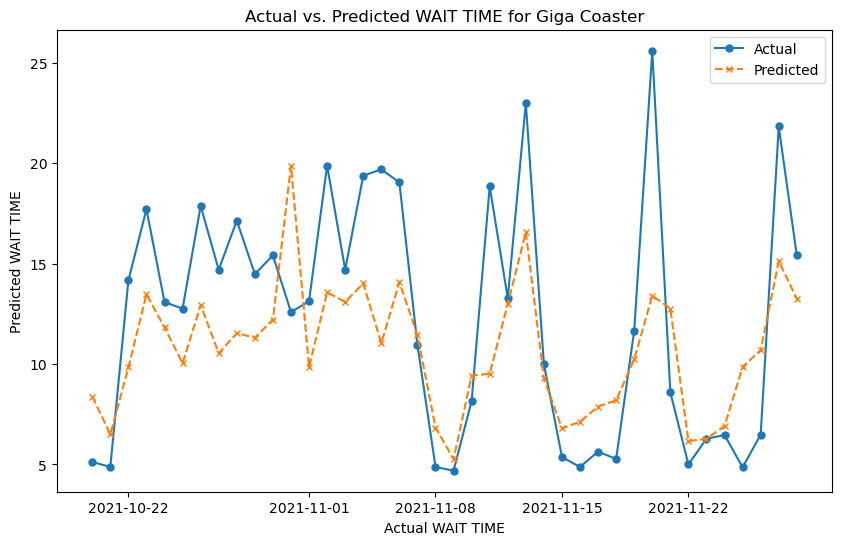

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Crazy Dance: 10.0
MAPE for Crazy Dance: 5288916778.06
R-squared for Crazy Dance: 0.0533
                                 Variable  Coefficient
4   REAL TIME ATTRACTION CLOSES FOR 15MIN    -0.214813
20                             IsPeakHour    -0.154963
18                                  Month    -0.082798
3                         ADJUST CAPACITY    -0.059300
16                  Ratio People/Capacity    -0.043675
17                              DayOfWeek    -0.040337
1                           GUEST CARRIED    -0.027671
9                              WIND SPEED    -0.026328
2                                CAPACITY    -0.019456
11                       CLOUD PERCENTAGE    -0.014324
6                             TEMPERATURE    -0.013162
15                            IS PARADE 2     0.000000
14                            IS PARADE 1     0.000000
0                                NB UNITS     0.000000
5                            NB MAX UNITS     0.000000
13               

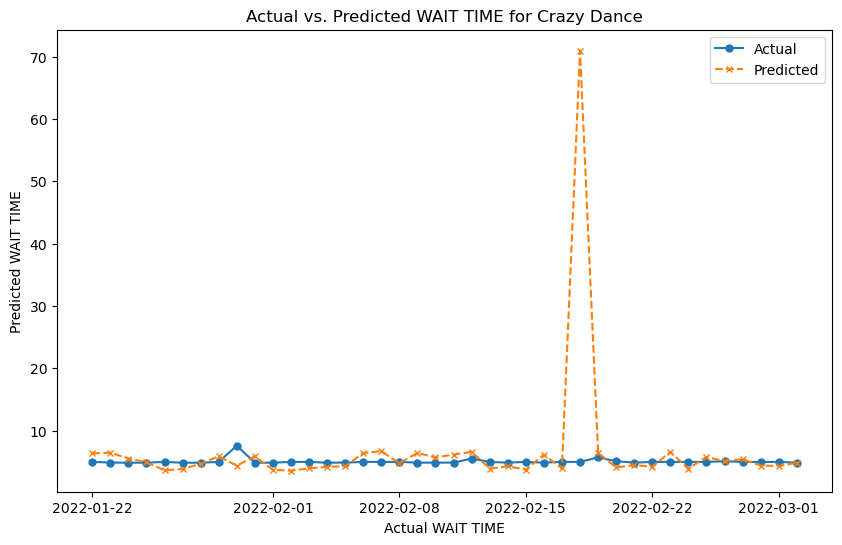

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Oz Theatre: 10.0
MAPE for Oz Theatre: 1933197772.17
R-squared for Oz Theatre: 0.5069
                                 Variable  Coefficient
12                             ATTENDANCE    -1.094664
3                         ADJUST CAPACITY    -0.585239
20                             IsPeakHour    -0.577874
11                       CLOUD PERCENTAGE    -0.384331
9                              WIND SPEED    -0.350945
4   REAL TIME ATTRACTION CLOSES FOR 15MIN    -0.350106
6                             TEMPERATURE    -0.194021
17                              DayOfWeek    -0.073740
8                                HUMIDITY    -0.030624
10                               WIND DEG    -0.023880
0                                NB UNITS    -0.008041
5                            NB MAX UNITS     0.000000
13                          IS NIGHT SHOW     0.000000
15                            IS PARADE 2     0.000000
7                                PRESSURE     0.037278
2                   

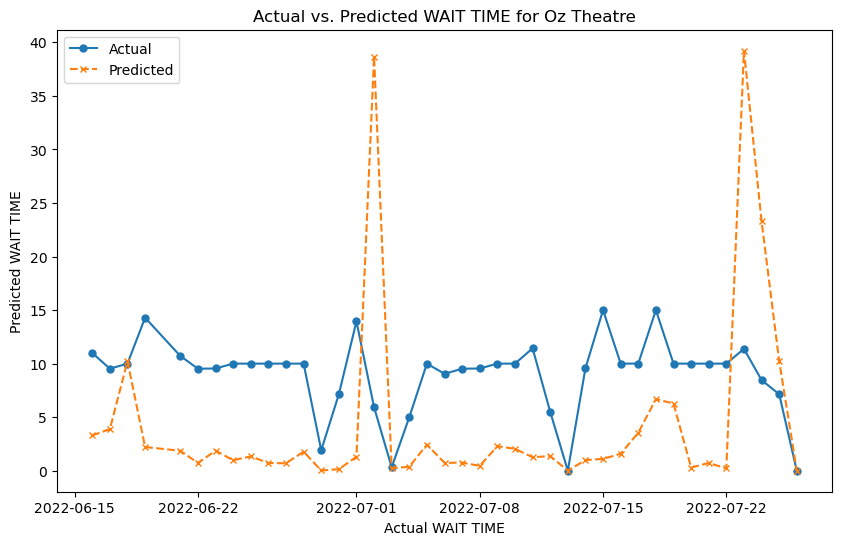

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Go-Karts: 10.0
MAPE for Go-Karts: 15.69
R-squared for Go-Karts: 0.7960
                                 Variable  Coefficient
14                            IS PARADE 1    -0.172326
18                                  Month    -0.081583
6                             TEMPERATURE    -0.072089
16                  Ratio People/Capacity    -0.071868
1                           GUEST CARRIED    -0.052077
17                              DayOfWeek    -0.034004
0                                NB UNITS    -0.005640
11                       CLOUD PERCENTAGE    -0.003820
3     REAL TIME ATTRACTION OPEN FOR 15MIN    -0.000822
5                            NB MAX UNITS     0.000000
15                            IS PARADE 2     0.000000
2                                CAPACITY     0.001729
19                              IsWeekend     0.005850
13                          IS NIGHT SHOW     0.005943
9                              WIND SPEED     0.006407
20                             IsP

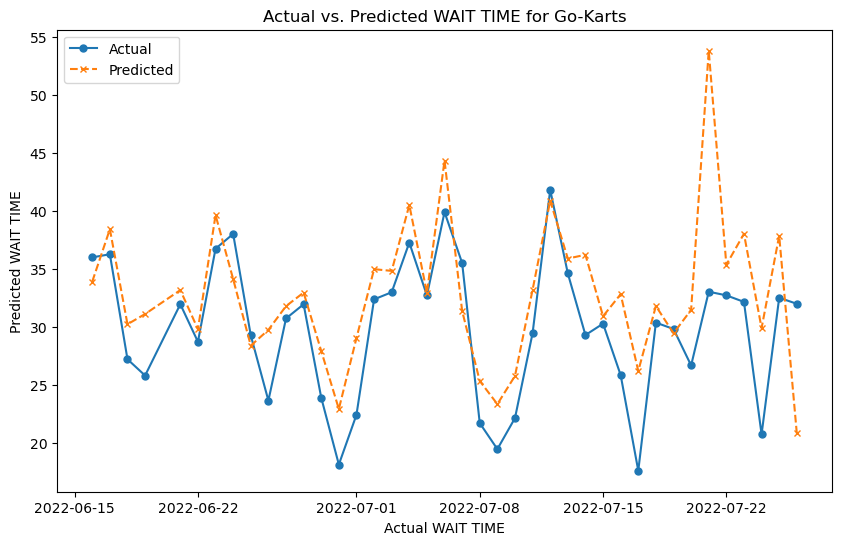

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Best alpha for Zipline: 10.0
MAPE for Zipline: 12.34
R-squared for Zipline: 0.7972
                                 Variable  Coefficient
14                          IS NIGHT SHOW    -0.056260
10                             WIND SPEED    -0.041896
20                              IsWeekend    -0.034615
12                       CLOUD PERCENTAGE    -0.021222
0                                NB UNITS    -0.002846
18                              DayOfWeek    -0.002427
3                         ADJUST CAPACITY    -0.001535
6                            NB MAX UNITS     0.000000
16                            IS PARADE 2     0.000000
4     REAL TIME ATTRACTION OPEN FOR 15MIN     0.000301
1                           GUEST CARRIED     0.000455
19                                  Month     0.002242
2                                CAPACITY     0.005796
5   REAL TIME ATTRACTION CLOSES FOR 15MIN     0.009034
9                                HUMIDITY     0.013958
7                             TEMPERA

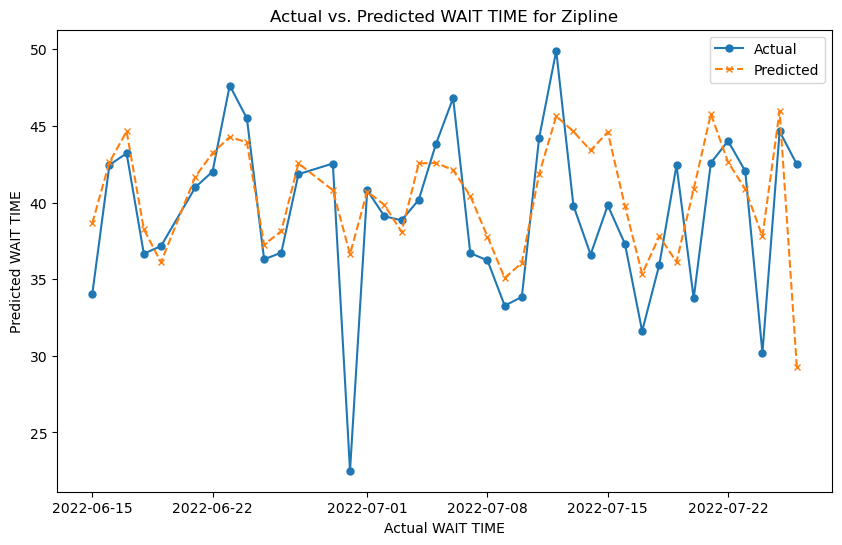

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_30042/1795925683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_attraction = df_attraction.groupby('DATE').mean()


Best alpha for Vertical Drop: 10.0
MAPE for Vertical Drop: 6.71
R-squared for Vertical Drop: 0.7085
                                 Variable   Coefficient
13                             ATTENDANCE -4.069957e-02
21                             IsPeakHour -3.145137e-02
2     REAL TIME ATTRACTION OPEN FOR 15MIN -2.167939e-02
15                            IS PARADE 1 -1.761572e-02
1                                CAPACITY -1.549939e-02
17                  Ratio People/Capacity -1.137238e-02
18                              DayOfWeek -3.909163e-03
9                                HUMIDITY -1.357704e-17
19                                  Month  0.000000e+00
16                            IS PARADE 2  0.000000e+00
14                          IS NIGHT SHOW  0.000000e+00
12                       CLOUD PERCENTAGE  0.000000e+00
10                             WIND SPEED  0.000000e+00
8                                PRESSURE  0.000000e+00
7                     TEMPERATURE MAXIMUM  0.000000e+00
6   

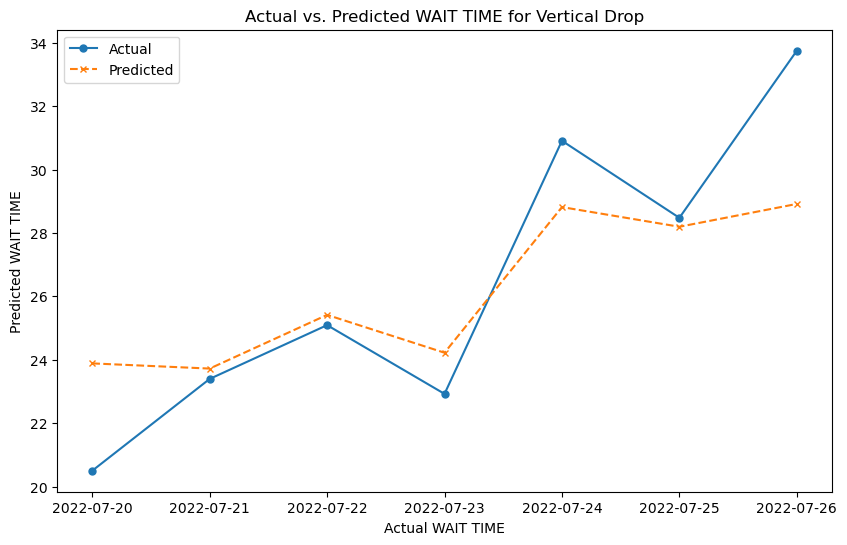

,Variable,Average Coefficient
0,MAPE value,3.208154e+08
1,R-squared,6.053670e-01
2,Best Alpha,9.240040e+00
3,GUEST CARRIED,2.582318e-02
4,IS PARADE 1,-6.127049e-03
5,Ratio People/Capacity,3.227532e-02
6,HUMIDITY,-1.272323e-02
7,DayOfWeek,-1.678709e-02
8,REAL TIME ATTRACTION CLOSES FOR 15MIN,-2.200117e-02
9,IS NIGHT SHOW,-3.218221e-03


In [120]:
coef_dic = {}  # Initialize the dictionary to store coefficients and R-squared

for attraction in attractions_name:
    df_attraction = df_15_bis[df_15_bis['ATTRACTION NAME'] == attraction]
    df_attraction = df_attraction.groupby('DATE').mean()
    df_attraction += 1e-10
    df_attraction = np.log(df_attraction)
    corr_matrix = df_attraction.select_dtypes(include=[np.number]).corr()
    high_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in high_corr.columns if any(high_corr[column] > 0.9) and column != 'Ratio People/Capacity']
    df_attraction.drop(columns=to_drop, inplace=True)

    X = df_attraction.drop('WAIT TIME', axis=1)
    y = df_attraction['WAIT TIME']

    # Replace inf/-inf with NaN and fill NaNs (if any)
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(X.mean(), inplace=True)

    X_const = sm.add_constant(X)

    features = X_const.loc[:, X_const.columns != 'const']
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    X_scaled = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
    X_scale_const = sm.add_constant(X_scaled)

    # Ridge Regression with Cross-Validation to find optimal alpha
    param_grid = {'alpha': [0.001, 0.01, 0.02 ,0.05, 0.1, 0.2, 0.5 1.0, 10.0]}  
    ridge_model = Ridge()
    grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_absolute_error') 
    grid_search.fit(X_scaled, y)

    best_alpha = grid_search.best_params_['alpha']
    best_model = grid_search.best_estimator_

    params = best_model.coef_
    params_df = pd.DataFrame({'Variable': X_scaled.columns[1:], 'Coefficient': params[1:]})
    params_df = params_df.sort_values(by='Coefficient')

    y_pred = best_model.predict(X_scaled)
    y_actual_exp = np.exp(y)
    y_pred_exp = np.exp(y_pred)
    mape = calculate_mape(y_actual_exp, y_pred_exp)
    r_squared = r2_score(y, y_pred)
    print(f"Best alpha for {attraction}: {best_alpha}")
    print(f"MAPE for {attraction}: {mape:.2f}")
    print(f"R-squared for {attraction}: {r_squared:.4f}")
    print(params_df)

    # Updating the dictionary
    coef_dic[attraction] = {'MAPE value': mape, 'R-squared': r_squared, 'Best Alpha': best_alpha}
    for i, row in params_df.iterrows():
        coef_name = row['Variable']
        coef_value = row['Coefficient']
        coef_dic[attraction][coef_name] = coef_value

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(y.index[-40:], y_actual_exp[-40:], label='Actual', marker='o', linestyle='-', markersize=5)
    plt.plot(y.index[-40:], y_pred_exp[-40:], label='Predicted', marker='x', linestyle='--', markersize=5)
    plt.xlabel('Actual WAIT TIME')
    plt.ylabel('Predicted WAIT TIME')
    plt.title(f'Actual vs. Predicted WAIT TIME for {attraction}')
    plt.legend()
    plt.show()

df_coefs = pd.DataFrame.from_dict(coef_dic, orient='index')

average_coefs = df_coefs.mean()
df_average_coefs = pd.DataFrame(average_coefs, columns=['Average Coefficient']).reset_index()
df_average_coefs.rename(columns={'index': 'Variable'}, inplace=True)

df_average_coefs
